# SENTIMENT ANALYSIS WITH HUGGING FACE MODELS

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries and Installations

In [11]:
# First we install the requirements needed to perform the modeling
!pip install huggingface_hub transformers datasets gradio pipreqs TextBlob emot
!pip install accelerate>=0.20.1
!pip install transformers[torch] accelerate -U

In [12]:
import os
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#import emoji
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
from transformers import RobertaForSequenceClassification
#from transformers import AutoModelForSequenceClassification

from matplotlib import axes
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import re,string, unicodedata
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import string

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

from transformers import pipeline
import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

## Loading the Dataset

In [19]:
# Load the dataset and display some values
#df = pd.read_csv('../data/Train.csv')

#Loading the datasets
%%time
df_train = pd.read_csv('/content/drive/MyDrive/LP5/Career_Accelerator_P5-NLP/Train.csv')



# Eliminating rows containing NaN values
df_train = df_train[~df_train.isna().any(axis=1)]



CPU times: user 55.7 ms, sys: 2.37 ms, total: 58 ms
Wall time: 74.1 ms


In [20]:
df_train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   9999 non-null   object 
 1   safe_text  9999 non-null   object 
 2   label      9999 non-null   float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


In [22]:
# Check for missing values

df_train.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [34]:
# Drop tweet_id column

df_train.drop('tweet_id', axis=1, inplace=True)

KeyError: ignored

In [35]:
df_train.head()

,safe_text,label,agreement
0,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,I mean if they immunize my kid with something ...,-1.0,1.0
4,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


# Data Visualisation

In [56]:
fig_1=px.histogram(data_frame= df_train, x= "label", title= "Distribution of Sentiments")
fig_1.show()

Notes:

- Most tweets were neutral
- There were more postive tweets than negative
- There is a random value which doesn't belong to any of our predefined class

In [57]:
##checking to find out the values of the random value:
df_train.label.unique()

array([ 0.,  1., -1.])

Using a WordCloud to Visualize Frequent Words

In [67]:
stopwords = STOPWORDS

In [68]:
len(stopwords)

192

In [69]:
wc= WordCloud(background_color= "black",
              stopwords=stopwords,

              height= 600,

              width= 400


             )

In [70]:
train_tweets = df_train["safe_text"].dropna()

In [71]:
train_text= " ".join("safe_text")

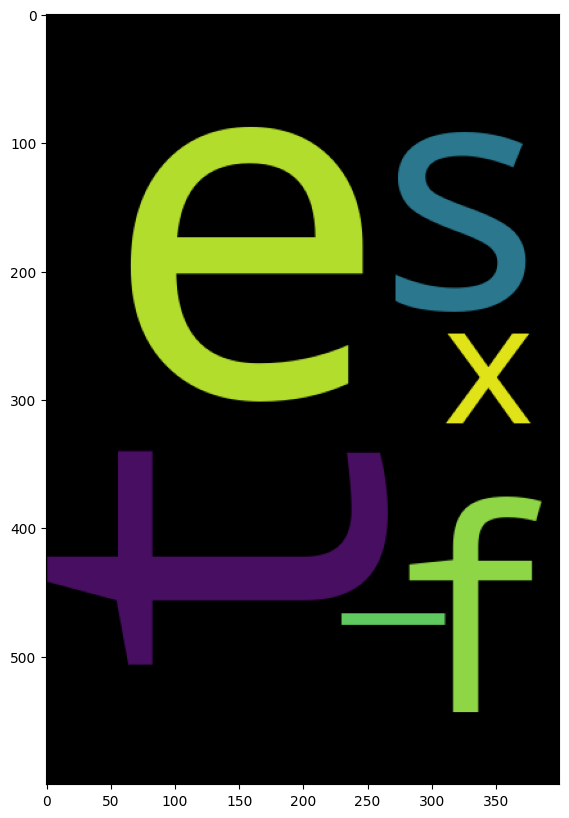

In [72]:
wc_train= wc.generate(train_text)
plt.figure(figsize= (15,10))
plt.imshow(wc_train)

In [36]:
# converting tweets to lower case

df_train["safe_text"]= df_train["safe_text"].str.lower()

In [37]:
df_train.head()

,safe_text,label,agreement
0,me &amp; the big homie meanboy3000 #meanboy #m...,0.0,1.0
1,i'm 100% thinking of devoting my career to pro...,1.0,1.0
2,"#whatcausesautism vaccines, do not vaccinate y...",-1.0,1.0
3,i mean if they immunize my kid with something ...,-1.0,1.0
4,thanks to <user> catch me performing at la nui...,0.0,1.0


### Removing puntuations and emojis

In [38]:
def punctuation_remover(text):
  #Define the regex pattern to match punctuations
  punctuation_pattern = r"[^\w\s]"

  #Replace punctuation with space
  text_without_punctuation = re.sub(punctuation_pattern,'',text)
  return text_without_punctuation

In [40]:
df_train["safe_text"]=df_train['safe_text'].apply(punctuation_remover)

### Remove user and url

In [41]:
def word_remover(text):
  return " ".join([word for word in text.split() if word not in ["url","user"]])

In [43]:
df_train["safe_text"]=df_train["safe_text"].apply(lambda x : word_remover(x))

In [45]:
df_train[930:940]

,safe_text,label,agreement
930,on average people who complain live longer rel...,0.0,1.000000
931,ncaa tourney editionhotfaking measles10minsago...,0.0,1.000000
932,immunizations for school,0.0,0.666667
933,object lesson re not vaccinating harrowing sto...,1.0,1.000000
934,rt a call about vaccines just came in mark rev...,1.0,1.000000
935,i always make sure i listen to mmr when is on ...,0.0,1.000000
936,original article intussusception risk after ro...,-1.0,0.666667
937,3 diseases were on the decline before the intr...,-1.0,1.000000
938,gop stop blaming immigrants first ebola now me...,0.0,1.000000
939,rubella measles officially eliminated from the...,0.0,0.666667


### Remove Stop words

In [46]:

nltk.download('stopwords')  # Download stopwords corpus (run once)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))  # Set of stopwords in English

    # Tokenize the text into individual words
    words = nltk.word_tokenize(text)

    # Remove stopwords from the text
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Join the filtered words back into a single string
    processed_text = ' '.join(filtered_words)

    return processed_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [49]:
df_train["safe_text"]=df_train['safe_text'].apply(remove_stopwords)

In [51]:
df_train[850:860]

,safe_text,label,agreement
850,mashable roald dahls heartbreaking 1988 letter...,0.0,1.000000
851,marketing job alert manager immunization progr...,0.0,1.000000
852,chicken pox vaccine kids fairly new given due ...,1.0,0.666667
853,vaccinate fucking kids,1.0,1.000000
854,cant even imagine angry scared parents tooyoun...,1.0,1.000000
855,measles count reaches 49 california scpick,0.0,1.000000
856,measles outbreak continues grow health officia...,0.0,0.666667
857,vaccines cause autism,0.0,0.666667
858,cooties shots allegheny county health departme...,0.0,0.666667
859,enough kristin cavallari ive read many books v...,-1.0,0.666667


Lemmetization of Safe Text Colunm

In [52]:
def perform_lemmatization(text):
  lemmatizer = WordNetLemmatizer()
  tokens=nltk.word_tokenize(text)
  lemmatized_words = [lemmatizer.lemmatize(token) for token in tokens]
  processed_text = ' '.join(lemmatized_words)
  return processed_text

In [53]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [54]:
df_train["safe_text"]=df_train['safe_text'].apply(perform_lemmatization)

In [55]:
df_train.head()

,safe_text,label,agreement
0,amp big homie meanboy3000 meanboy mb mb mmr st...,0.0,1.0
1,im 100 thinking devoting career proving autism...,1.0,1.0
2,whatcausesautism vaccine vaccinate child,-1.0,1.0
3,mean immunize kid something wont secretly kill...,-1.0,1.0
4,thanks catch performing la nuit nyc 1134 1st a...,0.0,1.0


# Saving the Dataset

In [73]:
df = df_train.copy()
df.to_csv('df.csv', index=False)

In [74]:
%%time
df = pd.read_csv('/content/df.csv')
df.tail(10)

CPU times: user 25.2 ms, sys: 2.82 ms, total: 28 ms
Wall time: 57 ms


,safe_text,label,agreement
9989,stop worrying theyll lose vaccination missing ...,1.0,1.000000
9990,dawg said gone rich one day eazybash mmr theca...,0.0,1.000000
9991,one half hour isa pdx mmr,0.0,1.000000
9992,doesnt want vaccinate kid would call fucking r...,1.0,0.666667
9993,ill say glad mom gave mmr vaccination little r...,1.0,1.000000
9994,living time sperm used waste jenny mccarthy be...,1.0,1.000000
9995,spite measles outbreak judge mi threatens put ...,1.0,0.666667
9996,interesting trend child immunization oklahoma ...,0.0,1.000000
9997,cdc say measles highest level decade returned u,0.0,1.000000
9998,pneumonia vaccine woman w risk pulmonary disea...,1.0,0.666667
